In [651]:
### Author: Gary Chen
### Date: June 13, 2023
### Last Updated: June 21, 2023
### Description: Radon Transform (img to sinogram)
###    in the process of implementing inverse radon

try:
    import numpy as np
except Exception as e:
    print("numpy Importing exception")
try:
    import matplotlib.pyplot as plt
except Exception as e:
    print("matplotlib Importing exception")
try:
    import torch
except Exception as e:
    print("torch Importing exception")  
try:
    import torchvision.transforms.functional as F
except Exception as e:
    print("torch Importing exception")  
from torchvision import transforms
print('pytorch version is ', torch.__version__)
import os
current_directory = os.getcwd()
print("Current directory:", current_directory)
target_directory = '/Users/garychen/Desktop/2023SummerResearch/Ganapati/RadonTorch/dataset_foam'
os.chdir(target_directory)

current_directory = os.getcwd()
print("Current directory:", current_directory)
files = os.listdir(current_directory)
print(files)

pytorch version is  2.0.0
Current directory: /Users/garychen/Desktop/2023SummerResearch/Ganapati/RadonTorch/dataset_foam
Current directory: /Users/garychen/Desktop/2023SummerResearch/Ganapati/RadonTorch/dataset_foam
['y_size.npy', 'x_size.npy', 'radon comp 0.png', 'rotate images 0.png', 'foam_training.npy', 'x_train_sinograms.npy', 'dataset_parameters.npy']


Using device: cpu


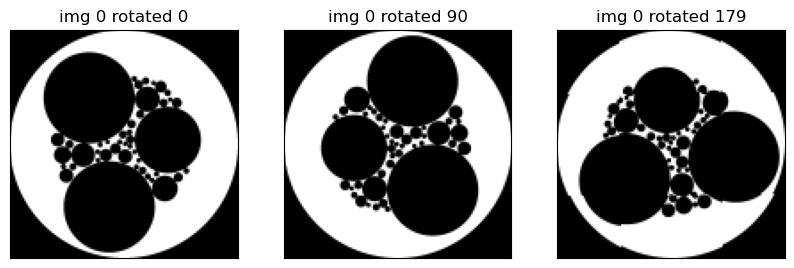

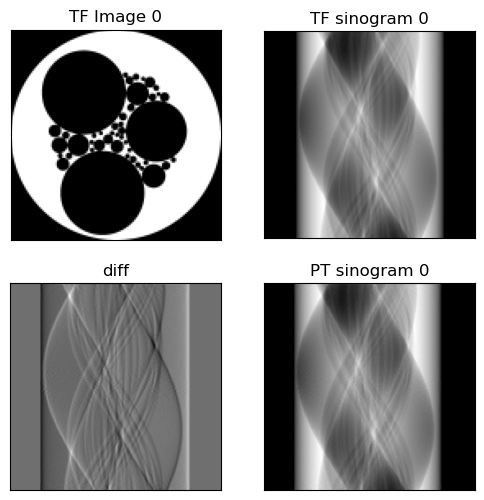

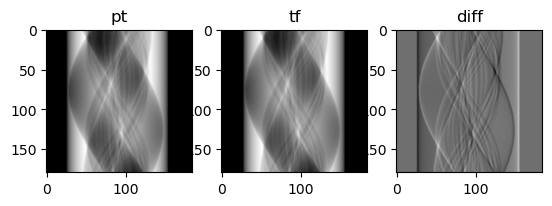

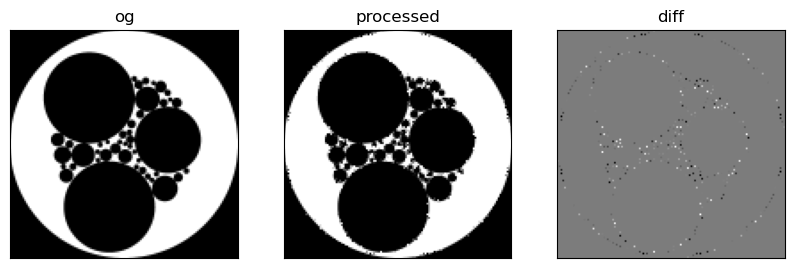

In [652]:
#%time # on Jupyter Notebook

class Data_loader:
    # load .npy file into PyTorch tensor and move it to GPU
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def npy_to_tensor(self, npy_file_path):
        np_data = np.load(npy_file_path)
        tensor = torch.from_numpy(np_data).to(self.device)
        return tensor


class Radon_Transform:
    # convert the img to sinogram
    def __init__(self):
        self.theta_num = 180
        self.angles = np.arange(90, 270, dtype=float) # Angle list
        self.size_x = None
        self.size_y = None
        
    def img_to_rotated_imgs(self, image):
        # initialize the collection of rotated iamges as 180 by 128 by 128 empty arrays
        assert type(self.theta_num) == int
        rotated_imgs = torch.zeros((self.theta_num,128, 128))
        #rotated_imgs = torch.zeros((180,128, 128))
        # assign the unrotated img as the first img in the rotated collection
        rotated_imgs[0,:,:] = image
        self.size_x = image.shape[0]
        self.size_y = image.shape[0]
        for i in range(1,self.theta_num):
            #print(f"angle type is {type(self.angles[i])}")
            #print(f"angle  is {self.angles[i]}")
            rotated_image = F.rotate(image.unsqueeze(0), -self.angles[i]) #rotate function requires img in 3-d dimension
            rotated_imgs[i,:,:] = rotated_image
        return rotated_imgs
    
    def rotated_imgs_to_sinogram(self, rotated_images):
        # initialize the summing vector
        sum_vec = torch.ones((self.size_x, 1))
        sinogram = torch.zeros((180, 184))
        assert type(self.theta_num) == int
        for i in range(self.theta_num):
        #for i in range(180):
            # ith_p is the i-th row of the sinogram corresponding to each angle
            ith_p = torch.matmul(rotated_images[i,:,:],sum_vec) # 128 by 128 @ 128 by 1 means sum across the all rows of the img
            # Calculate start index for ith row in the sinogram 
            start = (sinogram.shape[0] - ith_p.shape[0]) // 2
            # Assign p values to the ith row of the sinogram, centered
            sinogram[i,start:start+ith_p.shape[0]] = ith_p.reshape(-1)
        return sinogram 

class Display_Image:
    # display the images and sinograms and compare our implementations with CT-PVAE
    
    def display_rotated_imgs(self, rotated_images, img_id):
        rotate_fig, ax = plt.subplots(1, 3, figsize=(10, 6))
        ax[0].imshow(rotated_images[0,:,:].cpu().numpy(), cmap='gray')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title(f'img {img_id} rotated 0')
        ax[1].imshow(rotated_images[90,:,:].cpu().numpy(), cmap='gray')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title(f'img {img_id} rotated 90')
        ax[2].imshow(rotated_images[179,:,:].cpu().numpy(), cmap='gray')
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        ax[2].set_title(f'img {img_id} rotated 179')
        rotate_fig.savefig(f"rotate images {img_id}")
        plt.show()
    
    def display_radon_transform(self, img, img_id, tf_sinogram,pt_sinogram):
        # Create a figure and a 1x2 subplot grid
        fig, axs = plt.subplots(2, 2, figsize=(6, 6))
        axs[0,0].imshow(img.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[0,0].set_title(f'TF Image {img_id}')
        axs[0,1].imshow(tf_sinogram.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[0,1].set_title(f'TF sinogram {img_id}')
        axs[1,0].imshow(tf_sinogram.cpu().numpy()-pt_sinogram.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[1,1].imshow(pt_sinogram.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[1,0].set_title(f'diff')
        axs[1,1].set_title(f'PT sinogram {img_id}')

        # Remove the x and y ticks
        axs[0,0].set_xticks([])
        axs[0,0].set_yticks([])
        axs[0,1].set_xticks([])
        axs[0,1].set_yticks([])
        axs[1,0].set_xticks([])
        axs[1,0].set_yticks([])
        axs[1,1].set_xticks([])
        axs[1,1].set_yticks([])
        
        fig.savefig(f"radon comp {img_id}")
        plt.show()

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

data_loader = Data_loader()
radon_tranformer = Radon_Transform()
displayer = Display_Image()
img_id = 2
images_tensor = data_loader.npy_to_tensor('foam_training.npy')
tf_sinograms_tensor = data_loader.npy_to_tensor('x_train_sinograms.npy')
for img_id in range(1):
    image = images_tensor[img_id,:,:]
    rotated_images = radon_tranformer.img_to_rotated_imgs(image)
    pt_sinogram = radon_tranformer.rotated_imgs_to_sinogram(rotated_images)
    tf_sinogram = tf_sinograms_tensor[img_id,:,:]
    displayer.display_rotated_imgs(rotated_images, img_id)
    displayer.display_radon_transform(image, img_id, tf_sinogram,pt_sinogram)

def plot_2_img_tensor(image1, image2, title1, title2):
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(image1.cpu().numpy(), cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2.cpu().numpy(), cmap='gray')
    axs[1].set_title(title2)
    axs[2].imshow(image2.cpu().numpy()-image1.cpu().numpy(), cmap='gray')
    '''
    print('img 1 is', image1[50:60, 50:60])
    print('img 2 is', image2[50:60, 50:60])
    print('diff is', image2.cpu().numpy()[50:60, 50:60]-image1.cpu().numpy()[50:60, 50:60])
    '''
    axs[2].set_title('diff')
    plt.show()
    
plot_2_img_tensor(pt_sinogram,tf_sinogram,"pt","tf")

'''
print("images shape", images_tensor.shape)
print("image1 shape", image.shape)
print("image1 dtpye", image.dtype)
print("tf_sinograms_tensor shape", tf_sinograms_tensor.shape)
print("tf_sinogram shape", tf_sinogram.shape)
print("tf_sinogram dtpye", tf_sinogram.dtype)
'''

rotate_angle = 60
a = rotated_images[0]
b = rotated_images[rotate_angle]
c = F.rotate(b.unsqueeze(0),rotate_angle+90)
c = c.reshape(128,128)
def plot_2_img_tensor(image1, image2, title1, title2):
    fig, axs = plt.subplots(1, 3,figsize=(10, 6))
    axs[0].imshow(image1.cpu().numpy(), cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2.cpu().numpy(), cmap='gray')
    axs[1].set_title(title2)
    axs[2].imshow(image2.cpu().numpy()-image1.cpu().numpy(), cmap='gray')
    axs[2].set_title('diff')
    for i in range(len(axs)):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    plt.show()
plot_2_img_tensor(a,c,'og','processed')






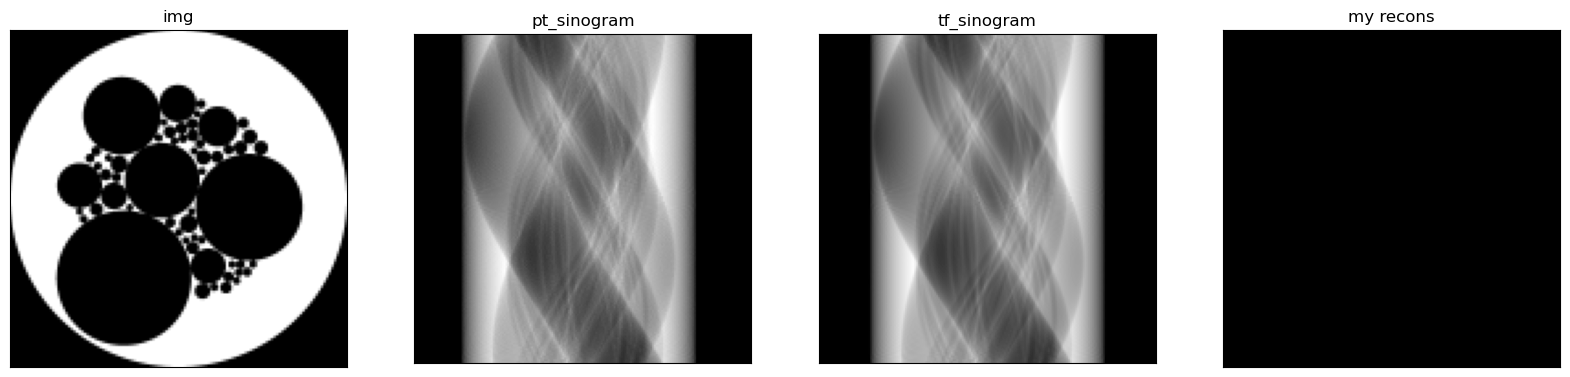

In [653]:
img_id = 1
image = images_tensor[img_id,:,:]
rotated_images = radon_tranformer.img_to_rotated_imgs(image)
pt_sinogram = radon_tranformer.rotated_imgs_to_sinogram(rotated_images)
tf_sinogram = tf_sinograms_tensor[img_id,:,:]
#displayer.display_rotated_imgs(rotated_images, img_id)
#displayer.display_radon_transform(image, img_id, tf_sinogram,pt_sinogram)

def plot_3_images(image1, image2, image3,image4, title1, title2, title3,title4):
    fig, axs = plt.subplots(1, 4,figsize=(20, 6))
    axs[0].imshow(image1.cpu().numpy(), cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2.cpu().numpy(), cmap='gray')
    axs[1].set_title(title2)
    axs[2].imshow(image3.cpu().numpy(), cmap='gray')
    axs[2].set_title(title3)
    axs[3].imshow(image4.cpu().numpy(), cmap='gray')
    axs[3].set_title(title4)
    for i in range(len(axs)):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    plt.show()
    
my_recon = torch.zeros_like(image)


plot_3_images(image,pt_sinogram,tf_sinogram,my_recon,'img','pt_sinogram','tf_sinogram','my recons')

tensor size torch.Size([128, 128])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


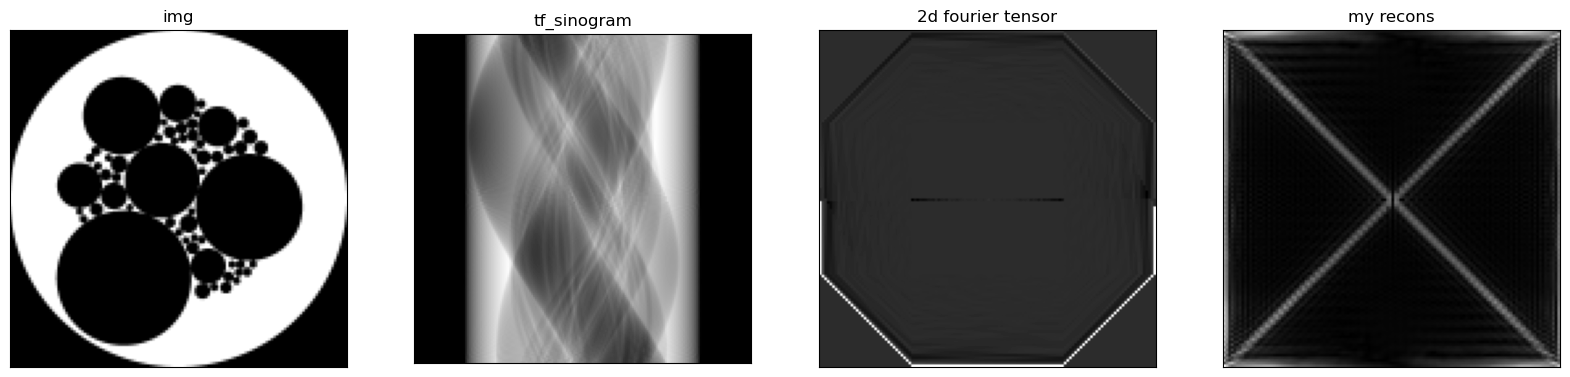

In [654]:
# inverse radon transform 
# input: sinogram from 180 angles
# output: the original image 
'''
process:
    1. initialize an empty 2d fourier array of size 128 by 128
    2. 1d fourier transform each row (angle) of sinogram into a tensor of different frequencies
    3. map the each frequency into the 2d fourier domain graph with formulas below:
        x = frequency * cos(angle)
        y = frequency * sin(angle)
        fourier_array[x,y] += projection_ft[ith-frequency]
    4. fill up the fourier array and perform a high pass filter on it
        high pass filter could be a linear ramp filter 
        high pass filter = (size the same as the fourier array with 0 at the center and radially increases outbound)
        filtered fourier array = fourier array * high pass filter (element wise multiplication)
    5. perform 2d inverse fourier transform to the filled and filtered fourier array
'''
def plot_1D_tensor(tensor):
    # Move tensor to CPU if it resides on a CUDA device
    if tensor.is_cuda:
        tensor = tensor.cpu()

    # Convert tensor to a numpy array
    tensor_array = tensor.numpy()

    # Plot the tensor
    plt.plot(tensor_array)
    plt.title("1D Tensor Plot")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.show()

def inverse_radon_transform(sinogram):
    img_w, img_h = (128,128)
    sino_w, sino_h = (184,180)
    # todo: crop the sinogram to 180 by 128 so that the 1d ft has 128 that could be map to the 2d ft tensor
    sinogram = sinogram[:,28:156]
    fourier_tensor = torch.zeros((128,128)).to(device) 
    pi = torch.acos(torch.zeros(1)).item()*2 # define pi as 3.1415927410125732
    print('tensor size', fourier_tensor.shape)
    assert fourier_tensor.shape == (128,128)
    x_axis_idx = fourier_tensor.shape[0]//2
    for i, projection_s in enumerate(sinogram):
        # i is the angle info; in our case 90 to 270
        rad_angle = torch.tensor(i, dtype=torch.int8) / pi
        rad_angle = rad_angle.to(device) 
        assert all(sinogram[i,:] == projection_s)
        projection_f = torch.fft.fft(projection_s).to(device)
        #assert projection_f.shape[0] == sino_w
        #plot_1D_tensor(projection_s)
        #plot_1D_tensor(projection_f)
        '''
                zero_fre = torch.tensor(projection_f[0]).reshape([1])
        pos_fre = projection_f[1:]
        neg_fre = pos_fre.flip(dims=[0])
        #print(f'pos_fre shape is {pos_fre.shape}')
        #print(f'neg_fre shape is {neg_fre.shape}')
        #print(f'zero_fre shape is {zero_fre.shape}')

        sym_fre = torch.cat((neg_fre,zero_fre,pos_fre))
        '''

        fourier_tensor[x_axis_idx] = fourier_tensor[x_axis_idx]+projection_f
        #print(f'sym fre is {sym_fre}')
        #print(f'neg fre is {neg_fre}')
        fourier_tensor = F.rotate(fourier_tensor.unsqueeze(0), 1).reshape(128,128)
        '''
        for j, frequency in enumerate(projection_f):
            # not sure if the math is correct for the bottom three lines of code
            frequency = torch.abs(frequency).to(device)
            x = int(frequency * torch.cos(rad_angle)/img_x)
            y = int(frequency * torch.sin(rad_angle)/img_y)
            #print(f'x is {x}')
            #print(f'y is {y}')
            #print(f'projection_f is {frequency}')
            fourier_tensor[x,y] += frequency
        '''
    '''
    # in the process of implementing another way of looping 
    for k, projection_s in enumerate(sinogram):
        rad_angle = torch.tensor(k, dtype=torch.int8) / pi
        rad_angle = rad_angle.to(device)
        assert all(sinogram[k,:] == projection_s)
        projection_f = torch.fft.fft(projection_s).to(device)
        print(f'projection_f has shape {projection_f.shape}')
        for y, row in enumerate(fourier_tensor):
            for x, col in enumerate(y):
                fourier_tensor[y,x] += 0
                break
    '''
    print(fourier_tensor)
    '''
    # perform high pass filter to the filled fourier array

    # Compute the distances to the center of the Fourier space for each point
    x = torch.arange(0, fourier_tensor.shape[0]).to(device)
    y = torch.arange(0, fourier_tensor.shape[1]).to(device)
    xx, yy = torch.meshgrid(x - fourier_tensor.shape[0] // 2, y - fourier_tensor.shape[1] // 2)
    distances = torch.sqrt(xx**2 + yy**2).to(device)

    # Create the high pass filter mask
    # For a linear ramp filter (high pass), the value at each point is proportional to its distance to the center
    filter_mask = distances

    # Shift the filter mask to align with the Fourier space
    # The DC component is at the corners in PyTorch's FFT output
    filter_mask = torch.fft.fftshift(filter_mask).to(device)

    # Apply the filter mask to the Fourier space
    #filtered_fourier_space = fourier_tensor * filter_mask

    # Now you can perform the inverse FFT to get the filtered image
    #filtered_image = torch.fft.ifft2(filtered_fourier_space).to(device)
    '''

    # object image from fourier domain to space domain
    filtered_image = torch.fft.ifft2(fourier_tensor).to(device)
    # The result is complex, take the absolute value to get the magnitude
    recon = torch.abs(filtered_image)
    #print(recon)
    plot_3_images(image,tf_sinogram,fourier_tensor,recon,'img','tf_sinogram','2d fourier tensor','my recons')
    return recon

#print(tf_sinogram[0,:])
recon = inverse_radon_transform(tf_sinogram)


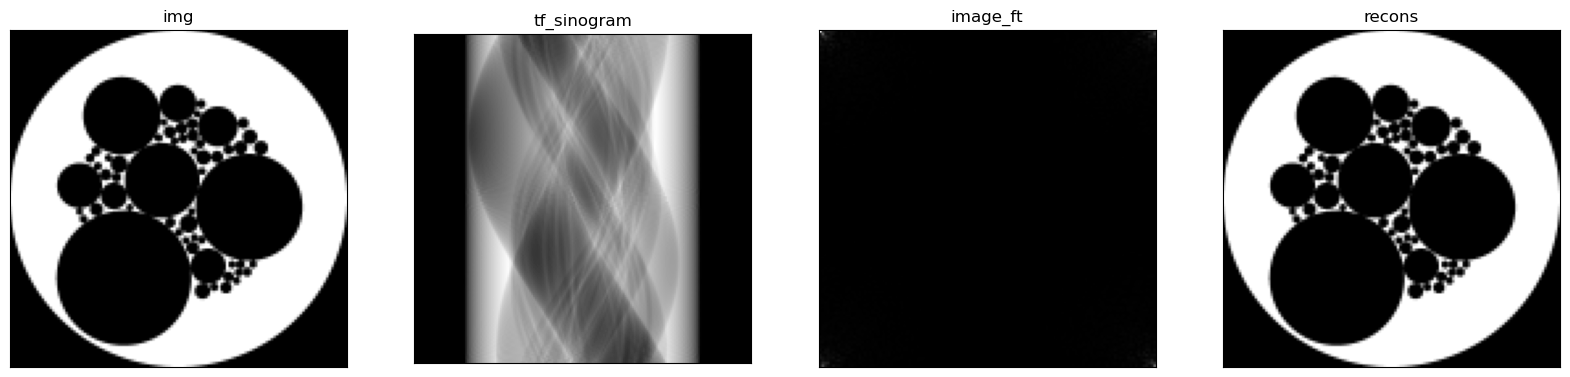

img shape is torch.Size([128, 128])
img_ft shape is torch.Size([128, 128])
recon shape is torch.Size([128, 128])
img_ft is tensor([[ 6796.7778+0.0000j,   451.4047+1066.0787j,    24.8153-550.5905j,
          ...,  -757.5121+164.6588j,    24.8153+550.5905j,
           451.4047-1066.0787j],
        [  206.5662-651.4960j, -2650.1968+365.5771j,  -476.6966+61.7520j,
          ...,    88.0364+259.9614j,  -486.2751+465.3187j,
         -1881.6151-363.6612j],
        [ -368.5454-177.3731j,  -783.7107-718.6532j,  1106.6715+187.3416j,
          ...,   669.0698-350.4495j,   862.1885-172.5135j,
          -258.7765+965.5425j],
        ...,
        [ -191.7119+166.7594j,   149.4854-440.2970j,    89.9493+247.0658j,
          ...,  -147.6947+329.7274j,   617.4919-483.8017j,
           205.5510+120.5000j],
        [ -368.5454+177.3731j,  -258.7765-965.5425j,   862.1885+172.5135j,
          ...,   568.2864-268.6329j,  1106.6715-187.3416j,
          -783.7107+718.6532j],
        [  206.5662+651.4960j, -188

In [655]:
image = images_tensor[img_id,:,:]
image_ft = torch.fft.fft2(image)
recon =torch.fft.ifft2(image_ft)
plot_3_images(image,tf_sinogram,abs(image_ft),abs(recon),'img','tf_sinogram','image_ft','recons')
print(f'img shape is {image.shape}')
print(f'img_ft shape is {image_ft.shape}')
print(f'recon shape is {recon.shape}')
print(f'img_ft is {image_ft}')

img_ft_left = image_ft[:,:image_ft.shape[1]//2]
img_ft_right = image_ft[:,image_ft.shape[1]//2:]
img_ft_right_flip = img_ft_right.flip(dims=[1])
print(img_ft_right_flip == img_ft_left)
print(image_ft[0,0])
print(image_ft[-1,-1])


In [656]:
import numpy as np
from scipy.fftpack import fft, ifft, fftfreq
from scipy.interpolate import interp1d


In [657]:
def iradon(radon_image, theta=None, output_size=None,
           filter="ramp", interpolation="linear", circle=False):
    """
    Inverse radon transform.

    Reconstruct an image from the radon transform, using the filtered
    back projection algorithm.

    Parameters
    ----------
    radon_image : array_like, dtype=float
        Image containing radon transform (sinogram). Each column of
        the image corresponds to a projection along a different angle. The
        tomography rotation axis should lie at the pixel index
        ``radon_image.shape[0] // 2`` along the 0th dimension of
        ``radon_image``.
    theta : array_like, dtype=float, optional
        Reconstruction angles (in degrees). Default: m angles evenly spaced
        between 0 and 180 (if the shape of `radon_image` is (N, M)).
    output_size : int
        Number of rows and columns in the reconstruction.
    filter : str, optional (default ramp)
        Filter used in frequency domain filtering. Ramp filter used by default.
        Filters available: ramp, shepp-logan, cosine, hamming, hann.
        Assign None to use no filter.
    interpolation : str, optional (default 'linear')
        Interpolation method used in reconstruction. Methods available:
        'linear', 'nearest', and 'cubic' ('cubic' is slow).
    circle : boolean, optional
        Assume the reconstructed image is zero outside the inscribed circle.
        Also changes the default output_size to match the behaviour of
        ``radon`` called with ``circle=True``.

    Returns
    -------
    reconstructed : ndarray
        Reconstructed image. The rotation axis will be located in the pixel
        with indices
        ``(reconstructed.shape[0] // 2, reconstructed.shape[1] // 2)``.

    Notes
    -----
    It applies the Fourier slice theorem to reconstruct an image by
    multiplying the frequency domain of the filter with the FFT of the
    projection data. This algorithm is called filtered back projection.
    """
    
    if radon_image.ndim != 2:
        raise ValueError('The input image must be 2-D')
    if theta is None:
        m, n = radon_image.shape # m is height and n is width; n is the number of projection and m is the number of pixels in each projection
        theta = np.linspace(0, 180, n, endpoint=False)
    else:
        theta = np.asarray(theta)
    if len(theta) != radon_image.shape[1]:
        raise ValueError("The given ``theta`` does not match the number of "
                         "projections in ``radon_image``.")
    
    #perform high pass filter and inverse radon 
    th = (3.1415986 / 180.0) * theta
    f = abs(torch.fft.fftfreq(128)).reshape(-1, 1)*2
    omega = 3.1415926 * f
    # shepp logan filter
    if filter == "ramp":
        pass
    elif filter == "shepp-logan":
        # Start from first element to avoid divide by zero
        f[1:] = f[1:] * torch.sin(omega[1:]) / omega[1:]
    elif filter == "cosine":
        f *= torch.cos(omega)
    elif filter == "hamming":
        f *= (0.54 + 0.46 * torch.cos(omega / 2))
    elif filter == "hann":
        f *= (1 + torch.cos(omega / 2)) / 2
    elif filter is None:
        f[:] = 1
    elif filter == "lifted_ramp":
        n = 128
        starting_point = 0.005
        x1 = torch.linspace(starting_point, 1, int(n/2))
        x2 = torch.linspace(1,starting_point, int(n/2))
        # Create an array that starts at 0.5, increases to 1 at the middle, 
        # then decreases to 0.5 at the end using absolute function
        y = torch.cat((x1, x2))
        f = y.reshape(-1, 1)
    else:
        raise ValueError("Unknown filter: %s" % filter)
    # shepp logan filter
    radon_ft = torch.fft.fft2(radon_image, axis=0)
    print(f'radon_ft shape: {radon_ft.shape}')
    projection = radon_ft* f
    radon_filtered = np.real(torch.fft.ifft2(projection, axis=0).numpy())

    # Resize filtered image back to original size
    radon_filtered = radon_filtered[:radon_image.shape[0], :]
    reconstructed = np.zeros((output_size, output_size))
    # Determine the center of the projections (= center of sinogram)
    mid_index = radon_image.shape[0] // 2

    [X, Y] = np.mgrid[0:output_size, 0:output_size]
    xpr = X - int(output_size) // 2
    ypr = Y - int(output_size) // 2

    # Reconstruct image by interpolation
    for i in range(len(theta)):
        # th is thera in radians
        t = ypr * np.cos(th[i]) - xpr * np.sin(th[i])
        x = np.arange(radon_filtered.shape[0]) - mid_index
        backprojected = np.interp(t, x, radon_filtered[:, i],
                                      left=0, right=0)
        reconstructed += backprojected
    
    return reconstructed

torch.Size([10, 1])
tensor([[0.0000],
        [0.2000],
        [0.4000],
        [0.6000],
        [0.8000],
        [1.0000],
        [0.8000],
        [0.6000],
        [0.4000],
        [0.2000]])


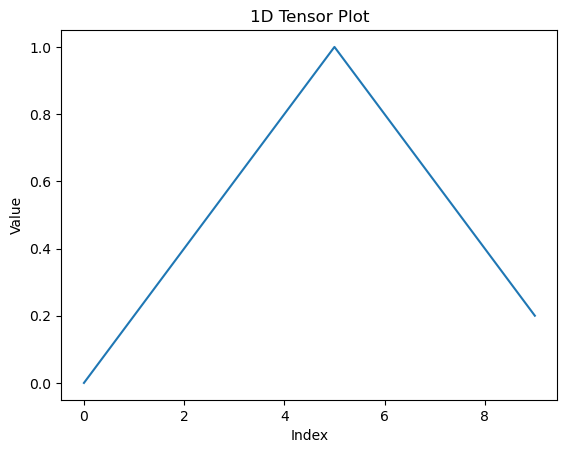

In [658]:
f1 = abs(torch.fft.fftfreq(10)).reshape(-1, 1)*2
print(f1.shape)
print(f1)
plot_1D_tensor(f1)

radon_ft shape: torch.Size([128, 180])
radon_ft shape: torch.Size([128, 180])
radon_ft shape: torch.Size([128, 180])
radon_ft shape: torch.Size([128, 180])
radon_ft shape: torch.Size([128, 180])
radon_ft shape: torch.Size([128, 180])
radon_ft shape: torch.Size([128, 180])


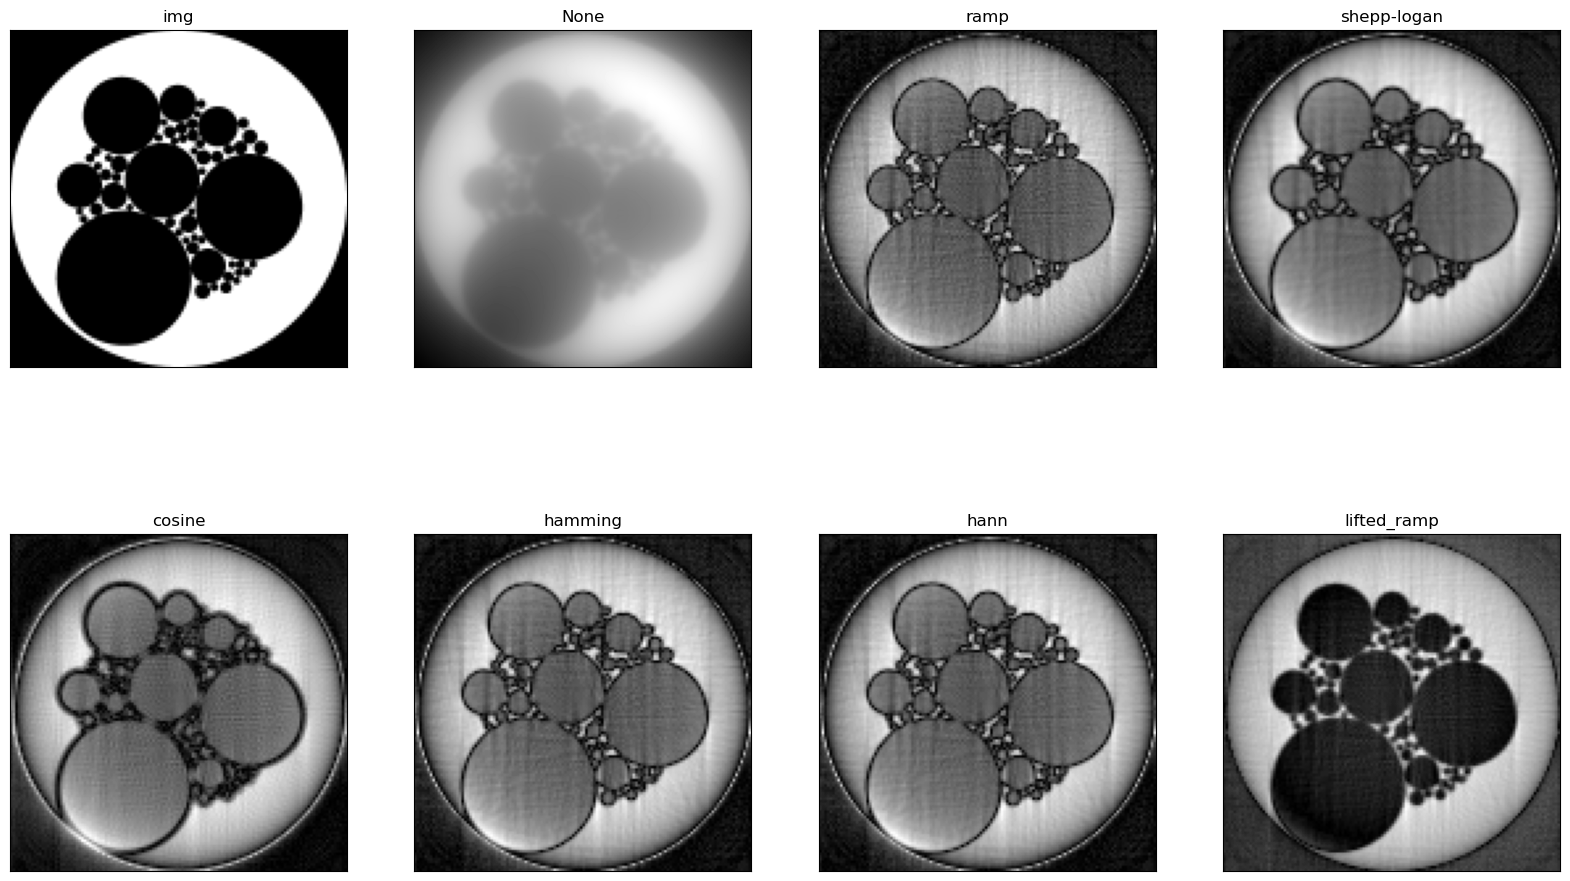

In [659]:

test_sinogram = tf_sinogram[:,28:28+128]
filters = [None,'ramp','shepp-logan','cosine','hamming','hann','lifted_ramp']
#filters = ['ramp']
recons = []
for filter in filters:
    recon = iradon(test_sinogram.T, theta=None, output_size=128,filter=filter)
    recon = torch.tensor(recon)
    recons.append(abs(recon))
def plot_8_images(image1, title1, image2,title2, image3,title3,image4,title4,image5, title5, image6,title6, image7,title7,image8,title8):
    fig, axs = plt.subplots(2, 4,figsize=(20, 12))
    axs[0,0].imshow(image1.cpu().numpy(), cmap='gray')
    axs[0,0].set_title(title1)
    axs[0,1].imshow(image2.cpu().numpy(), cmap='gray')
    axs[0,1].set_title(title2)
    axs[0,2].imshow(image3.cpu().numpy(), cmap='gray')
    axs[0,2].set_title(title3)
    axs[0,3].imshow(image4.cpu().numpy(), cmap='gray')
    axs[0,3].set_title(title4)
    axs[1,0].imshow(image5.cpu().numpy(), cmap='gray')
    axs[1,0].set_title(title5)
    axs[1,1].imshow(image6.cpu().numpy(), cmap='gray')
    axs[1,1].set_title(title6)
    axs[1,2].imshow(image7.cpu().numpy(), cmap='gray')
    axs[1,2].set_title(title7)
    axs[1,3].imshow(image8.cpu().numpy(), cmap='gray')
    axs[1,3].set_title(title8)
    for i in range(4):
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])
        axs[1,i].set_xticks([])
        axs[1,i].set_yticks([])
    plt.show()

plot_8_images(image,'img',recons[0],'None',recons[1],filters[1],recons[2],filters[2],recons[3],filters[3],recons[4],filters[4]
              ,recons[5],filters[5],recons[6],filters[6])    